# imports

In [1]:
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential


In [2]:
import os
import sys

sys.path.append(os.path.abspath("../src"))

In [3]:
from src import *

# flags

In [4]:
db = database_loader.DatabaseLoader(get_config('connection_string'))
DEBUG = False
SCHEMA = 'controls'

file_name = "ml_stats_dataset"
data_directory = get_config('data_directory')
project_name = get_config('project_name')

input_path = os.path.join(data_directory, project_name,  f"{file_name}.parquet")
assert  os.path.exists(input_path)


# load the NFL stats dataset

In [5]:
stats_df = pd.read_parquet(input_path)
stats_df.head()

,season,week,spread,rush_attempts,rush_touchdowns,pass_touchdowns,interceptions,fumble,own_kickoff_recovery,safety,...,passing_air_yards,passing_yards_after_catch,avg_dakota,carries,rushing_yards,receptions,targets,receiving_yards,receiving_air_yards,receiving_yards_after_catch
index,,,,,,,,,,,,,,,,,,,,,
0,2022,1,-23,0,1,2,0,6,0,0,...,267.0,115.0,0.007858,22.0,103.0,24.0,36.0,205.0,266.0,115.0
1,2022,3,-8,3,0,0,0,2,0,0,...,356.0,166.0,-0.000555,21.0,70.0,37.0,55.0,314.0,332.0,166.0
2,2022,4,10,5,0,2,1,3,0,0,...,180.0,87.0,0.011065,37.0,132.0,23.0,31.0,207.0,182.0,87.0
3,2022,6,-10,5,0,0,1,4,0,0,...,333.0,114.0,0.003919,28.0,144.0,23.0,36.0,222.0,340.0,114.0
4,2022,7,8,2,1,1,0,2,0,0,...,216.0,94.0,0.013561,29.0,137.0,20.0,29.0,204.0,216.0,94.0


# perform feature selection



## prepare our data for feature selection
We'll have an X, and y set plus the original stats_df datasets, which we'll use going forward

In [6]:
stats_df['win'] = np.where(stats_df['spread'] > 0, 1, 0)
stats_df.drop(columns=['spread'], inplace=True)

In [7]:
dtype_mapping = {col: 'float' for col in stats_df.select_dtypes(include='int64')}
stats_df = stats_df.astype(dtype_mapping)

In [8]:
assert 0 == stats_df.isnull().sum().sum()

## create X, y datasets
In additional to the whole stats_df dataset - which we will also use going forward

In [9]:
X = stats_df.drop(columns=['win']).copy()
y = stats_df['win']

print(X.shape)
print(y.shape)
y.value_counts()

(3569, 62)
(3569,)


1.0    2064
0.0    1505
Name: win, dtype: int64

## define some helper functions

In [10]:
from typing import Set, Any


def correlate_to_target(df: pd.DataFrame, target_column: str, top_n: int) -> (pd.DataFrame, Set):

    # Calculate correlation matrix
    correlation_matrix = df.corr()

    # Filter and sort correlation coefficients by absolute value
    corr_df = pd.DataFrame(correlation_matrix.abs().unstack().sort_values(ascending=False))
    corr_df.reset_index(inplace=True)
    corr_df.columns = ['x', 'y', 'corr']

    not_self_correlated = (corr_df.y != target_column)
    win_correlated = (corr_df.x == target_column)

    df = corr_df.loc[ win_correlated & not_self_correlated ]\
        .sort_values(by='corr', ascending=False)\
        .drop(columns=['x'])\
        .head(top_n)\
        .copy()

    s = set(df['y'].values)

    return df, s


def calc_feature_importance(X: pd.DataFrame, y: pd.Series, top_n=30) -> (pd.DataFrame, Set):
    # Create an XGBoost model
    model = xgb.XGBRegressor()

    # Fit the model
    model.fit(X, y)

    # Get feature importance scores
    importance_scores = model.feature_importances_

    # Sort feature importance scores
    sorted_indices = importance_scores.argsort()[::-1]
    sorted_scores = importance_scores[sorted_indices]
    feature_names = X.columns[sorted_indices]

    # Get the top 'n' feature importance scores and names
    top_scores = sorted_scores[:top_n]
    top_features = feature_names[:top_n]
    df = pd.DataFrame({'y': top_features, 'corr': top_scores})

    set_xg_cols = set(top_features)
    return df, set(top_features)


def plot_correlations(scores: Any, features: Any, title: str):

    # Plot feature importance
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(scores)), scores, align='center')
    plt.yticks(range(len(features)), features)
    plt.xlabel('Score')
    plt.ylabel('Column')
    plt.title(title)
    plt.show()




## get the columns that are best correlated to our WIN/LOSS target

In [11]:
top_correlations, set_correlations = correlate_to_target(stats_df, 'win', 30)

## calculate the importance of each feature

In [12]:
top_features, set_features = calc_feature_importance(X, y, top_n=30)


## review correlations and feture importance

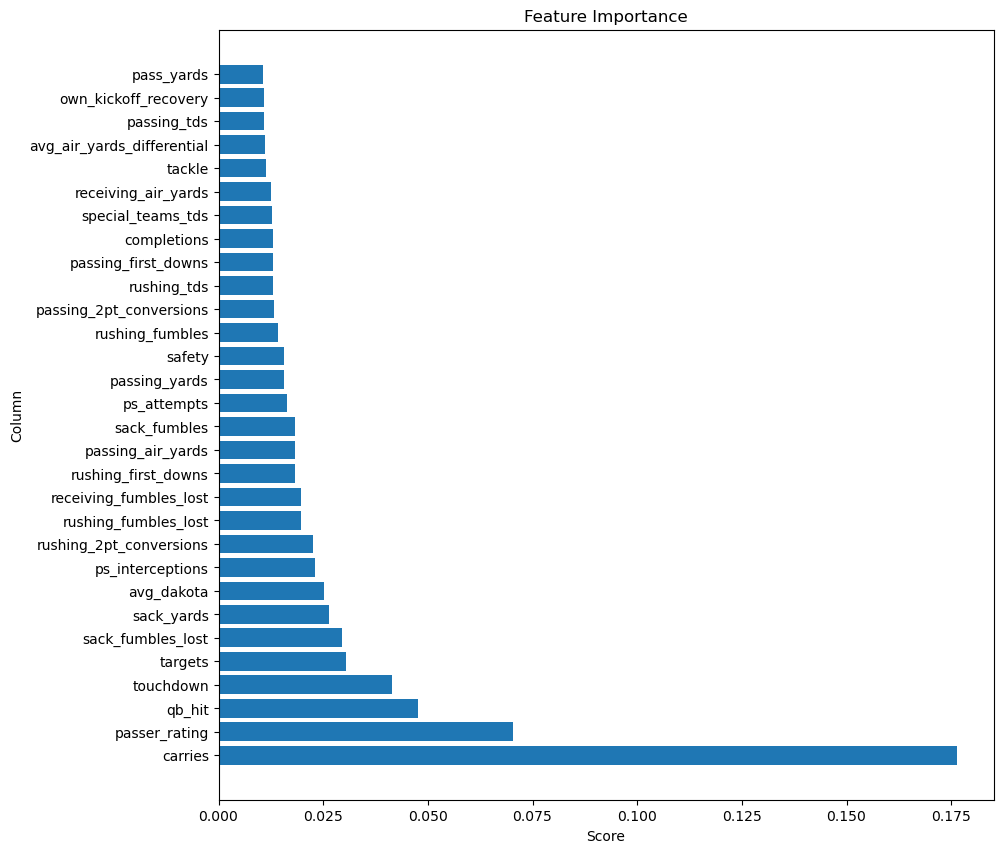

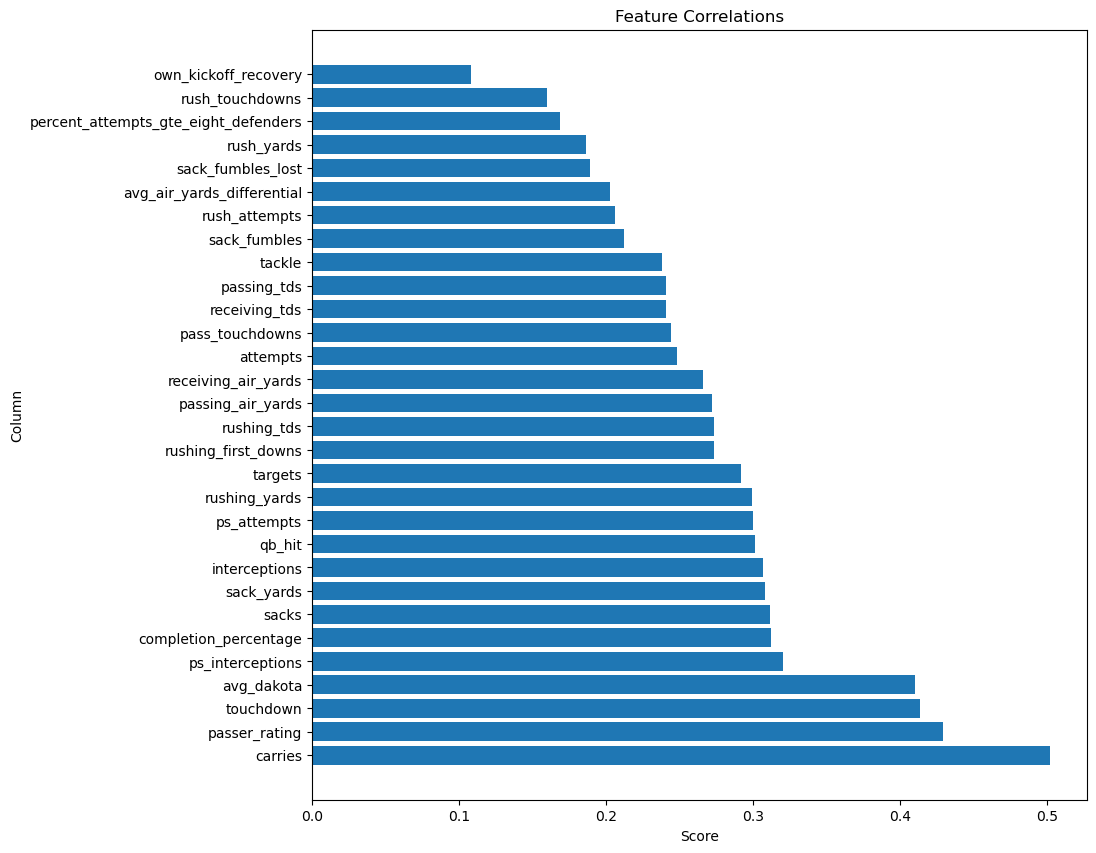

In [13]:
plot_correlations(top_features['corr'], top_features['y'], "Feature Importance")
plot_correlations(top_correlations['corr'], top_correlations['y'], 'Feature Correlations')

##  finally, decide what dimensions are worth keeping

In [14]:
target_columns = list(set_features.union(set_correlations))
X = X[target_columns]

# Validate that our dimensions support an ML project

## create train and test sets

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Create the scaler object
scaler = MinMaxScaler()

# Normalize selected columns in a DataFrame
X = scaler.fit_transform(X)


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)


## test our chosen features with a neural network

In [17]:
from keras.src.callbacks import EarlyStopping
from keras.src.optimizers import Adam
from keras import regularizers


learning_rate = .001
loss_function = 'binary_crossentropy'
epochs = 200
batch_size=32


# Create a neural network model
model = Sequential()
model.add(Dense(32, input_dim=X.shape[1], activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1, activation='sigmoid'))  # Single output neuron for binary classification

model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=loss_function,
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


# Train the model
r = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), callbacks=[early_stopping])



Epoch 1/200


2023-07-08 17:24:34.076919: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-07-08 17:24:34.076940: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-07-08 17:24:34.076943: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-07-08 17:24:34.077286: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-07-08 17:24:34.077457: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-07-08 17:24:34.395192: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 9ms/step - loss: 3.2390 - accuracy: 0.5183 - val_loss: 2.3843 - val_accuracy: 0.5821
Epoch 2/200
 9/95 [=>............................] - ETA: 0s - loss: 2.3298 - accuracy: 0.5590

2023-07-08 17:24:35.309259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 1s 8ms/step - loss: 1.7666 - accuracy: 0.5770 - val_loss: 1.2330 - val_accuracy: 0.5858
Epoch 3/200
95/95 [==============================] - 1s 7ms/step - loss: 0.9274 - accuracy: 0.5770 - val_loss: 0.7234 - val_accuracy: 0.5858
Epoch 4/200
95/95 [==============================] - 1s 7ms/step - loss: 0.6951 - accuracy: 0.5770 - val_loss: 0.6828 - val_accuracy: 0.5858
Epoch 5/200
95/95 [==============================] - 1s 7ms/step - loss: 0.6844 - accuracy: 0.5770 - val_loss: 0.6813 - val_accuracy: 0.5858
Epoch 6/200
95/95 [==============================] - 1s 7ms/step - loss: 0.6842 - accuracy: 0.5770 - val_loss: 0.6814 - val_accuracy: 0.5858
Epoch 7/200
95/95 [==============================] - 1s 7ms/step - loss: 0.6841 - accuracy: 0.5770 - val_loss: 0.6812 - val_accuracy: 0.5858
Epoch 8/200
95/95 [==============================] - 1s 7ms/step - loss: 0.6841 - accuracy: 0.5770 - val_loss: 0.6812 - val_accuracy: 0.5858
Epoch 9/200
95/95 [======

## evaluate our results

#### review scores

In [18]:
# Make predictions with the model
y_pred_prob = model.predict(X_test)  # Predicted probabilities
y_pred = np.where(y_pred_prob > 0.5, 1, 0)

# Calculate precision, recall, and F1 scores
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("")
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

17/17 [==============================] - 0s 1ms/step

Precision: 0.585820895522388
Recall: 1.0
F1-score: 0.7388235294117647


2023-07-08 17:24:44.902122: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


#### plot loss

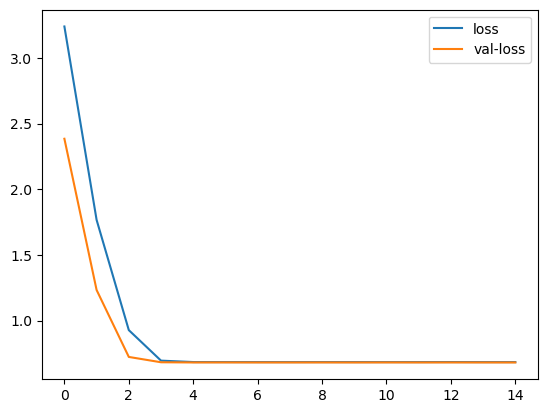

In [19]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val-loss')
plt.legend()
plt.show()

#### plot accuracy

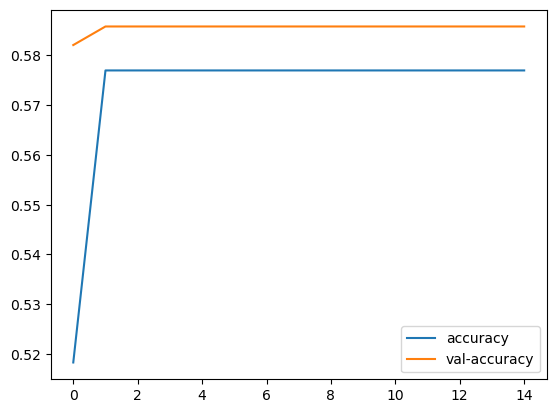

In [20]:
# Evaluate the model
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val-accuracy')
plt.legend()
plt.show()

#### plot confusion matrix

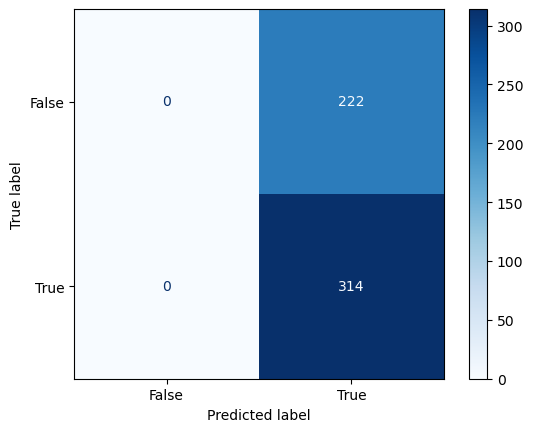

In [21]:
cm = confusion_matrix(y_pred=y_pred, y_true=y_test)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])

cm_display.plot(cmap='Blues')
plt.show()

# Save model and data

#### save model

In [22]:
model_directory = get_config("model_directory")
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
full_model_path = os.path.join(model_directory, "nfl_features_model.h5")
model.save(full_model_path)

/Users/christopherlomeli/anaconda3/envs/ml_tensorflow/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#### save normalized data

In [23]:
data_directory = get_config('data_directory')
if not os.path.exists(data_directory):
    os.makedirs(data_directory)

full_path = os.path.join(data_directory, "nfl_ml_features_scaled.npz")
np.savez(full_path, X=X, y=y)

### save dataframe with selected feature

In [24]:
full_path = os.path.join(data_directory, "nfl_ml_features.parquet")
stats_df.to_parquet(full_path)